In [1]:
from qibo.cskim_utils.gen_circuit import qibo_to_qiskit_cz, random_control_circuit_qibo
from qibo.cskim_utils.connectivity import *
from qibo.cskim_utils.qiskit_sabre import SabreSwap_old
from qibo.transpiler.optimizer import Preprocessing
from qibo.transpiler.pipeline import Passes
from qibo.transpiler.placer import Trivial
from qibo.transpiler.router import Sabre
from qiskit.transpiler import CouplingMap, Layout, PassManager
from qiskit.transpiler.passes import SetLayout, ApplyLayout
from qiskit.transpiler.passes import SabreSwap
from time import time
import numpy as np
import matplotlib.pyplot as plt
from qibo.cskim_utils.circuit_info import count_swaps_qibo, count_swaps_qiskit


In [3]:
def runtime_comparison(repeat, nqubits, ngates, swap_threshold, conn, cmap):
    swap_qibo_sabre = []
    swap_qiskit_sabre = []
    swap_qiskit_sabre_old = []

    time_qibo_sabre = []
    time_qiskit_sabre = []
    time_qiskit_sabre_old = []

    reset_count_qibo = []
    reset_count_qiskit_old = []

    for i in range(repeat):

        cz_circuit_qibo = random_control_circuit_qibo(nqubits, ngates)
        cz_circuit_qiskit = qibo_to_qiskit_cz(cz_circuit_qibo)

        router_sabre = Sabre(connectivity=conn, swap_threshold=swap_threshold)
        placer_trivial = Trivial(connectivity=conn)
        pipeline_qibo_sabre = Passes([placer_trivial, router_sabre], connectivity=conn)

        coup = CouplingMap(couplinglist=cmap)
        q = cz_circuit_qiskit.qubits
        pass_qiskit_sabre = PassManager()
        pass_qiskit_sabre.append(SetLayout(Layout({q[i]: i for i in range(nqubits)})))
        pass_qiskit_sabre.append(ApplyLayout())
        pass_qiskit_sabre.append(SabreSwap(coup, "decay"))

        pass_qiskit_sabre_old = PassManager()
        pass_qiskit_sabre_old.append(SetLayout(Layout({q[i]: i for i in range(nqubits)})))
        pass_qiskit_sabre_old.append(ApplyLayout())
        qiskit_router_sabre = SabreSwap_old(coup, "decay")
        pass_qiskit_sabre_old.append(qiskit_router_sabre)

        qibo_sabre_start = time()
        transpiled_qibo_sabre, _ = pipeline_qibo_sabre(cz_circuit_qibo)
        qibo_sabre_end = time()
        swap_count_qibo_sabre = count_swaps_qibo(transpiled_qibo_sabre)
        swap_qibo_sabre.append(swap_count_qibo_sabre)
        time_qibo_sabre.append(qibo_sabre_end - qibo_sabre_start)

        qiskit_sabre_start = time()
        transpiled_qiskit_sabre = pass_qiskit_sabre.run(cz_circuit_qiskit)
        qiskit_sabre_end = time()
        swap_count_qiskit_sabre = count_swaps_qiskit(transpiled_qiskit_sabre)
        swap_qiskit_sabre.append(swap_count_qiskit_sabre)
        time_qiskit_sabre.append(qiskit_sabre_end - qiskit_sabre_start)

        qiskit_sabre_old_start = time()
        transpiled_qiskit_sabre_old = pass_qiskit_sabre_old.run(cz_circuit_qiskit)
        qiskit_sabre_old_end = time()
        swap_count_qiskit_sabre_old = count_swaps_qiskit(transpiled_qiskit_sabre_old)
        swap_qiskit_sabre_old.append(swap_count_qiskit_sabre_old)
        time_qiskit_sabre_old.append(qiskit_sabre_old_end - qiskit_sabre_old_start)
    
        time_qibo_sabre_ms = [int(1000 * x) for x in np.array(time_qibo_sabre)]
        time_qiskit_sabre_ms = [int(1000 * x) for x in np.array(time_qiskit_sabre)]
        time_qiskit_sabre_old_ms = [int(1000 * x) for x in np.array(time_qiskit_sabre_old)]

        reset_count_qibo.append(router_sabre._reset_count)
        reset_count_qiskit_old.append(qiskit_router_sabre._reset_count)

    print("{:20s} {:>10s} {:>15s}".format(" ", "avg swaps", "avg time (ms)"))
    print("{:20s} {:10.3f} {:15.3f}".format("qibo sabre", sum(swap_qibo_sabre)/repeat, sum(time_qibo_sabre_ms)/repeat))
    print("{:20s} {:10.3f} {:15.3f}".format("qiskit sabre old", sum(swap_qiskit_sabre_old)/repeat, sum(time_qiskit_sabre_old_ms)/repeat))
    print("{:20s} {:10.3f} {:15.3f}".format("qiskit sabre", sum(swap_qiskit_sabre)/repeat, sum(time_qiskit_sabre_ms)/repeat))
    print("\nqibo avg {0} resets, qiskit old avg {1} resets".format(sum(reset_count_qibo)/repeat, sum(reset_count_qiskit_old)/repeat))

# Runtime Comparison

- Qibo Sabre
- Qiskit Sabre (old): no rust implementation
- Qiskit Sabre

### Connectivities, n_qubits

- cycle, 10, 20
- complete, 10, 20
- grid, 16
- iqm20, 20
- star, 5

### swap_threshold

- Qibo's SABRE reverts the circuit to the saved circuit when `swap_threshold * max_len_of_DAG` is reached.

## Star

### 5 qubits

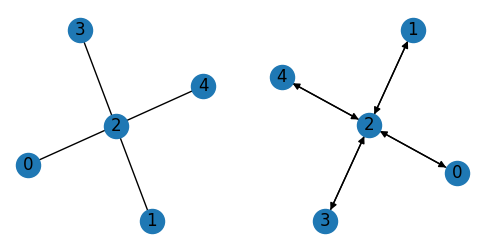

In [55]:
conn = star_connectivity_nx()
cmap = star_connectivity_cmap()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
nx.draw(conn, with_labels=True)
plt.subplot(1, 2, 2)
gcmap = nx.DiGraph(cmap)
nx.draw(gcmap, with_labels=True)

In [8]:
nqubits = 5
conn = star_connectivity_nx()
cmap = star_connectivity_cmap()
runtime_comparison(repeat=100, nqubits=nqubits, ngates=50, swap_threshold=1.5, conn=conn, cmap=cmap)

                      avg swaps   avg time (ms)
qibo sabre               16.090          71.570
qiskit sabre old         18.800           3.050
qiskit sabre             18.270           1.010

qibo avg 0.0 resets, qiskit old avg 0.0 resets


## Cycle

### 10 qubits

- No looping behavior
- Qibo SABRE runtime is **10x** longer than Qiskit SABRE and **50x** longer than Qiskit SABRE (Rust).

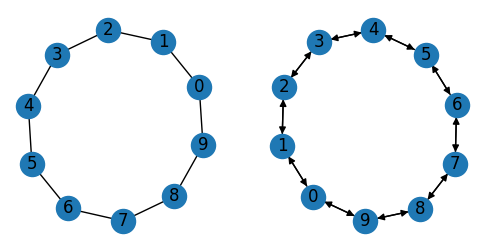

In [50]:
nqubits = 10
conn = cycle_connectivity_nx(nqubits)
cmap = cycle_connectivity_cmap(nqubits)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
nx.draw(conn, with_labels=True)
plt.subplot(1, 2, 2)
gcmap = nx.DiGraph(cmap)
nx.draw(gcmap, with_labels=True)

In [53]:
nqubits = 10
conn = cycle_connectivity_nx(nqubits)
cmap = cycle_connectivity_cmap(nqubits)
runtime_comparison(repeat=100, nqubits=nqubits, ngates=50, swap_threshold=1.5, conn=conn, cmap=cmap)

                      avg swaps   avg time (ms)
qibo sabre               57.250         126.290
qiskit sabre old         59.610          10.970
qiskit sabre             58.090           2.030

qibo avg 0.0 resets, qiskit old avg 0.0 resets


### 20 qubits

- The looping behavior only occurs in Qibo

In [54]:
nqubits = 20
conn = cycle_connectivity_nx(nqubits)
cmap = cycle_connectivity_cmap(nqubits)
runtime_comparison(repeat=100, nqubits=nqubits, ngates=50, swap_threshold=1.5, conn=conn, cmap=cmap)

                      avg swaps   avg time (ms)
qibo sabre              201.680         560.810
qiskit sabre old        142.550          32.190
qiskit sabre            137.330           2.650

qibo avg 16.28 resets, qiskit old avg 0.0 resets


### 20 qubits, large swap threshold

In [55]:
nqubits = 20
conn = cycle_connectivity_nx(nqubits)
cmap = cycle_connectivity_cmap(nqubits)
runtime_comparison(repeat=100, nqubits=nqubits, ngates=50, swap_threshold=10, conn=conn, cmap=cmap)

                      avg swaps   avg time (ms)
qibo sabre              445.810        1360.460
qiskit sabre old        142.450          34.710
qiskit sabre            136.220           2.760

qibo avg 10.55 resets, qiskit old avg 0.0 resets


## iqm-20

### 20 qubits

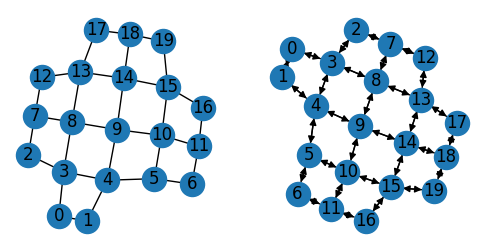

In [49]:
nqubits = 20
conn = iqm_connectivity_nx()
cmap = iqm_connectivity_cmap()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
nx.draw(conn, with_labels=True)
plt.subplot(1, 2, 2)
gcmap = nx.DiGraph(cmap)
nx.draw(gcmap, with_labels=True)

In [4]:
nqubits = 20
conn = iqm_connectivity_nx()
cmap = iqm_connectivity_cmap()
runtime_comparison(repeat=100, nqubits=nqubits, ngates=50, swap_threshold=1.5, conn=conn, cmap=cmap)

                      avg swaps   avg time (ms)
qibo sabre              146.920         478.270
qiskit sabre old         54.000          20.460
qiskit sabre             51.890           2.210

qibo avg 11.87 resets, qiskit old avg 0.0 resets


## Complete

### 10 qubits

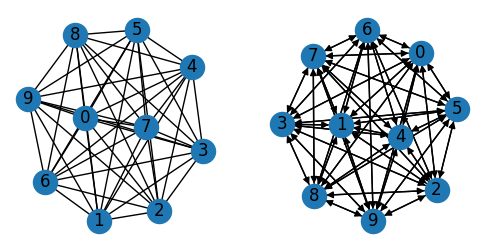

In [44]:
nqubits = 10
conn = complete_connectivity_nx(nqubits)
cmap = complete_connectivity_cmap(nqubits)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
nx.draw(conn, with_labels=True)
plt.subplot(1, 2, 2)
gcmap = nx.DiGraph(cmap)
nx.draw(gcmap, with_labels=True)

In [24]:
nqubits = 10
conn = complete_connectivity_nx(nqubits)
cmap = complete_connectivity_cmap(nqubits)
runtime_comparison(repeat=100, nqubits=nqubits, ngates=50, swap_threshold=1.5, conn=conn, cmap=cmap)

                      avg swaps   avg time (ms)
qibo sabre                0.000          33.650
qiskit sabre old          0.000           1.000
qiskit sabre              0.000           1.000

qibo avg 0.0 resets, qiskit old avg 0.0 resets


### 20 qubits

In [23]:
nqubits = 20
conn = complete_connectivity_nx(nqubits)
cmap = complete_connectivity_cmap(nqubits)
runtime_comparison(repeat=100, nqubits=nqubits, ngates=50, swap_threshold=1.5, conn=conn, cmap=cmap)

                      avg swaps   avg time (ms)
qibo sabre                0.000          24.140
qiskit sabre old          0.000           2.570
qiskit sabre              0.000           1.060

qibo avg 0.0 resets, qiskit old avg 0.0 resets


## Grid (Nakamura)

### 16 qubits

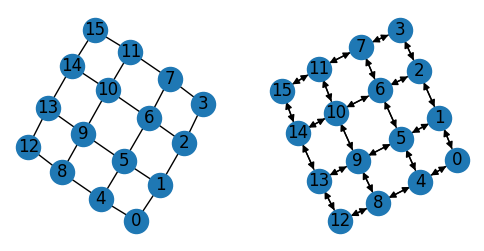

In [53]:
nqubits = 20
conn = nakamura_connectivitiy_nx()
cmap = nakamura_connectivity_cmap()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
nx.draw(conn, with_labels=True)
plt.subplot(1, 2, 2)
gcmap = nx.DiGraph(cmap)
nx.draw(gcmap, with_labels=True)

In [5]:
nqubits = 16
conn = nakamura_connectivitiy_nx()
cmap = nakamura_connectivity_cmap()
runtime_comparison(repeat=100, nqubits=nqubits, ngates=50, swap_threshold=1.5, conn=conn, cmap=cmap)

                      avg swaps   avg time (ms)
qibo sabre              139.640         377.510
qiskit sabre old         45.600          14.350
qiskit sabre             43.240           2.000

qibo avg 11.59 resets, qiskit old avg 0.0 resets
